In [ ]:
import torch
from torch import nn
import torch.nn.functional as F


params_down = {
    "padding": 1,
    "kernel_size": 4,
    "stride": 2,
    "dilation": 1,
    "padding_mode": "replicate",
}


params_up = {
    "padding": 1,
    "kernel_size": 3,
    "stride": 1,
    "dilation": 1,
    "padding_mode": "replicate",
    "bias": True,
}



def my_add_module(self, module):
    self.add_module(str(len(self) + 1), module)

torch.nn.Module.add = my_add_module

class goDown(nn.Module):
    """
    HxWout = HxWin // 2
    """

    def __init__(self, dims_in, dims_out):
        super(goDown, self).__init__()
        self.down = nn.Sequential()
        self.down.add(nn.Conv2d(dims_in, dims_out, **params_down))
        self.down.add(nn.ReLU())

    def forward(self, x):
        return self.down(x)
    

class goUp_pixel(nn.Module):
    """
    HxWout = HxWin // 2
    """

    def __init__(self, dims_in, dims_out):
        super(goUp_pixel, self).__init__()
        self.up = nn.Sequential()
        self.up.add(nn.PixelShuffle(2))
        self.up.add(nn.Conv2d(dims_in // 4, dims_out, **params_up))
        self.up.add(nn.ReLU())

    def forward(self, x):
        return self.up(x)


class goUp_nearest(nn.Module):
    """
    HxWout = HxWin // 2
    """

    def __init__(self, dims_in, dims_out):

        super(goUp_nearest, self).__init__()
        self.up = nn.Sequential()
        self.up.add(nn.Upsample(scale_factor=2, mode="nearest"))
        self.up.add(nn.Conv2d(dims_in, dims_out, **params_up))
        self.up.add(nn.ReLU())

    def forward(self, x):
        return self.up(x)


class UnetLike(nn.Module):
    def __init__(
        self, scale=4, mode="", dims_in=3):
        super(UnetLike, self).__init__()


        self.layers_down = nn.ModuleList()
        self.layers_up = nn.ModuleList()
        self.scale = scale
        # dims_in = 3

        dims_out = 8
        dims_mid = dims_in
        for i in range(scale):
            dims_out *= 2
            self.layers_down.append(goDown(dims_mid, dims_out))
            dims_mid = dims_out

        self.layers_down.append(nn.Conv2d(dims_mid, dims_mid, **params_up))
        self.layers_down.append(nn.ReLU())

        if mode == "nearest":
            goUp = goUp_nearest
        if mode == "pixel":
            goUp = goUp_pixel

        dims_mid = 2 * dims_out  # 256
        # in   256 128 64 32
        # out   64  32 16  3
        for i in range(scale):
            dims_out = dims_mid // 4 if i + 1 != scale else dims_in
            self.layers_up.append(goUp(dims_mid, dims_out))
            dims_mid = dims_mid // 2 


    def forward(self, x):
        down_outputs = []
        for i in range(self.scale):
            x = self.layers_down[i](x)
            down_outputs.append(x)

        x_up = self.layers_down[i + 1](x)  # 128
        # c_down = 8*2**4 = 128
        # c_up = c_down*2 = 256
        down_outputs.reverse()
        for i in range(self.scale):
            x_down = down_outputs[i]  # 128, 64, 32, 16
            x_cat = torch.cat((x_up, x_down), dim=1)  # 256, 128, 64, 32
            x_up = self.layers_up[i](x_cat)  # 128, 64, 32, 3

        return x_up


In [ ]:
model = UnetLike(scale=6, mode='nearest', dims_in=3)
model.cuda()
model(z)

In [ ]:
!wget "https://www.ksat.com/resizer/2Kr0JOMa5CwQBn1fVLPc_0WN7Uk=/1280x720/smart/filters:format(jpeg):strip_exif(true):strip_icc(true):no_upscale(true):quality(65)/arc-anglerfish-arc2-prod-gmg.s3.amazonaws.com/public/WZF3HRU66VCOLF55M6BYATB65A.jpg"

--2020-07-08 17:07:23--  https://www.ksat.com/resizer/2Kr0JOMa5CwQBn1fVLPc_0WN7Uk=/1280x720/smart/filters:format(jpeg):strip_exif(true):strip_icc(true):no_upscale(true):quality(65)/arc-anglerfish-arc2-prod-gmg.s3.amazonaws.com/public/WZF3HRU66VCOLF55M6BYATB65A.jpg
Resolving www.ksat.com (www.ksat.com)... 23.46.48.10, 23.46.48.91
Connecting to www.ksat.com (www.ksat.com)|23.46.48.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110181 (108K) [image/jpeg]
Saving to: ‘WZF3HRU66VCOLF55M6BYATB65A.jpg’

WZF3HRU66VCOLF55M6B 100%[===================>] 107.60K  --.-KB/s    in 0.08s   

2020-07-08 17:07:24 (1.30 MB/s) - ‘WZF3HRU66VCOLF55M6BYATB65A.jpg’ saved [110181/110181]



In [ ]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def random_crops(image, patches=4):
    w,h,_ = image.shape
    patches_xy = []
    for i in range(patches):
        x_patch, y_patch = int(np.random.random()*w), int(np.random.random()*h)
        patch_w = int(w*0.15)
        image[x_patch:x_patch+patch_w,y_patch:y_patch+patch_w] = 0
        patches_xy.append((x_patch, y_patch, patch_w))
    return image, patches_xy

(512, 1024, 3)


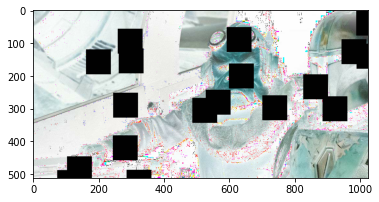

In [ ]:
image = plt.imread('WZF3HRU66VCOLF55M6BYATB65A.jpg').copy()
image.setflags(write=1)
x,y, _ = image.shape
x,y = 2**int(math.log(x,2)), 2**int(math.log(y,2))
image = image[0:x,0:y]
plt.imshow(image)

im_corrupted, patches_xy = random_crops(image, patches=18)
plt.imshow(1-im_corrupted) 
print(im_corrupted.shape)

In [ ]:
from copy import deepcopy
import torch.nn.functional as F
from torch import optim

In [ ]:
model_one = UnetLike(scale=8, mode='nearest', dims_in=3)
model_one.cuda();

x,w,_ = im_corrupted.shape
z  = torch.randn((1, 3,w,x))
z = z.cuda()

optimizer_one = optim.Adam(model_one.parameters(), lr=0.001)

loss_fn = F.mse_loss

image_tensor = torch.tensor(im_corrupted).unsqueeze(0).transpose(1,3).type(torch.float32)/255
image_tensor = image_tensor.cuda()
image_tensor.shape == z.shape

True

In [ ]:
def plot_tensor(image, epoch=None):
    image = image.transpose(1,3).detach().cpu().numpy()[0]
    f, ax = plt.subplots(2,1, figsize=(10,10))
    ax[0].imshow(image)
    ax[1].imshow(im_corrupted)
    if epoch:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    

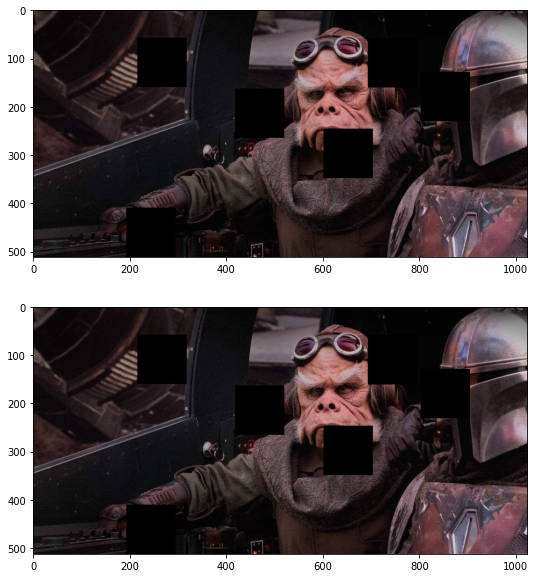

In [ ]:
plot_tensor(image_tensor)

In [ ]:
patches_xy

[(296, 658, 29),
 (441, 175, 70),
 (258, 475, 99),
 (185, 795, 154),
 (26, 276, 73),
 (198, 523, 48)]

In [ ]:
epochs = 1250

for i in range(epochs):
    optimizer_one.zero_grad()
    out = model_one(z)
    if i%40 == 0:
        plot_tensor(out, i)
    for p in patches_xy:
        out[:,:,p[1]:p[1]+p[2],p[0]:p[0]+p[2]] = 0
    loss = loss_fn(out, image_tensor)
    loss.backward()
    optimizer_one.step()
    
  

RuntimeError: ignored

In [ ]:
epochs = 1300

for i in range(epochs):
    optimizer_one.zero_grad()
    out = model_two(z)
    if i%20 == 0:
        plot_tensor(out, i)
    for p in patches_xy:
        out[:,:,p[1]:p[1]+p[2],p[0]:p[0]+p[2]] = 0
    loss = loss_fn(out, image_tensor)
    loss.backward()
    optimizer_one.step()
    
  

In [ ]:
import glob
import imageio

anim_file = 'nearest_three.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
      
    image = imageio.imread(filename)
    writer.append_data(image)
    writer.append_data(image)
    writer.append_data(image)

  writer.append_data(image)
  writer.append_data(image)
  writer.append_data(image)
  writer.append_data(image)
  writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import os

for file_name in os.listdir('./'):
    if file_name.endswith('.png'):
        print(file_name)
        file_path = os.remove(file_name)

image_at_epoch_0080.png
image_at_epoch_1740.png
image_at_epoch_1220.png
image_at_epoch_0060.png
image_at_epoch_2160.png
image_at_epoch_0580.png
image_at_epoch_1020.png
image_at_epoch_0400.png
image_at_epoch_1580.png
image_at_epoch_2400.png
image_at_epoch_1200.png
image_at_epoch_1060.png
image_at_epoch_1660.png
image_at_epoch_0740.png
image_at_epoch_0200.png
image_at_epoch_0320.png
image_at_epoch_2320.png
image_at_epoch_1380.png
image_at_epoch_2220.png
image_at_epoch_0420.png
image_at_epoch_1840.png
image_at_epoch_0020.png
image_at_epoch_2340.png
image_at_epoch_1920.png
image_at_epoch_1520.png
image_at_epoch_2180.png
image_at_epoch_1500.png
image_at_epoch_0600.png
image_at_epoch_1360.png
image_at_epoch_1140.png
image_at_epoch_2020.png
image_at_epoch_1640.png
image_at_epoch_0900.png
image_at_epoch_0780.png
image_at_epoch_0540.png
image_at_epoch_0500.png
image_at_epoch_1900.png
image_at_epoch_0480.png
image_at_epoch_2260.png
image_at_epoch_0660.png
image_at_epoch_2440.png
image_at_epoch_1

In [ ]:
!convert -delay 20 -loop 0 *png animated.gif

/bin/bash: convert: command not found
